In [1]:
import os
import sys
import multiprocessing as mp

# a hack to import module from different directory
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import tqdm
import numpy as np
import commpy as cp
from commpy.modulation import QAMModem
from commpy.channelcoding import Trellis

from radioml.radio_receivers import ModularReceiver
from radioml.decoders import ViterbiDecoder, NeuralDecoder
from radioml.demodulators import ClassicDemodulator, NeuralDemodulator
import radioml.utils as utils

## Define paramters for the comparison

In [2]:
class Params:
    SNR_RANGE = [0.0, 5.0, 10.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0]
    NUM_SAMPLES = 10000
    BLOCK_LENGTH = 100
    BPSK, QPSK, QAM16, QAM64 = 2, 4, 16, 64
    
# For encoding/decoding convolutional codes
G = np.array([[0o7, 0o5]]) 
M = np.array([2])
trellis = Trellis(M, G, feedback=0o7, code_type='rsc')
modem = QAMModem(m=Params.QPSK)

## Define helper function to simulate sending signals over AWGN Channel

In [3]:
def generate_signal_over_awgn(modem, block_length=100, snr_dB=15.0):
    message_bits   = np.random.randint(0, 2, block_length)
    encoded_bits   = cp.channelcoding.conv_encode(message_bits, trellis)
    modulated_bits = modem.modulate(encoded_bits)
    corrupted_bits = cp.channels.awgn(modulated_bits, snr_dB, rate=1/2)
    
    return message_bits, modulated_bits, corrupted_bits

def signal_generator(modulation_scheme, num_examples, block_length, snr_dB):
    with mp.Pool(mp.cpu_count()) as pool:
        result = pool.starmap(generate_signal_over_awgn,
                iterable=[(modulation_scheme, block_length, snr_dB) \
                          for i in range(num_examples)])
        orignal_msg_bits, moded_bits, noisy_outputs = zip(*result)
    return (np.array(orignal_msg_bits), np.array(moded_bits), np.array(noisy_outputs))

## Define two Receivers:
 
* **Baseline Receiver**: Classic Demod + Viterbi
* **Modular Receiver**: Classic Demod + RNN

In [4]:
classic_demod   = ClassicDemodulator(modem)
viterbi_decoder = ViterbiDecoder(trellis, tb_depth=15, decoding_type='hard')
neural_decoder  = NeuralDecoder(model_path='../models/BiGRU_BSC.hdf5', block_length=100)

baseline_receiver = ModularReceiver(classic_demod, viterbi_decoder)
neural_receiver  =  ModularReceiver(classic_demod, neural_decoder)

## Evaluate Baseline  on multiple SNRs

* For each SNR, generate `Params.NUM_SAMPLES` message bits and noisy signals.
* Run Baseline/Modular version on the same inputs
* Compute Bit error Rate, Block error rate

In [5]:
ber_logs, bler_logs = [], []
for i, snr in enumerate(Params.SNR_RANGE):
    (original_bits, clean_signals, noisy_signals) = signal_generator(
        modem,
        Params.NUM_SAMPLES, 
        Params.BLOCK_LENGTH, 
        snr)
    
    # ####################################
    # Run Baseline/Neral Receiver
    # ####################################
    with mp.Pool(mp.cpu_count()) as pool:
        baseline_estimated = pool.map(baseline_receiver, [i for i in noisy_signals])
  
    nn_estimated = neural_receiver(noisy_signals, True)
    
    # ####################################
    # Measure Accuracy / error
    # #################################### 
    # For decoder
    ber, bler        = utils.get_ber_bler(np.array(baseline_estimated)[:, :100], 
                                          original_bits)
    nn_ber, nn_bler  = utils.get_ber_bler(nn_estimated, original_bits)
    ber_logs.append([ber, nn_ber])
    bler_logs.append([bler, nn_bler])
    
    print('SNR_dB = %f' % snr)
    print('\t[Modular]  Ber = {:.8f} | Bler ={:.8f}'.format(nn_ber, nn_bler))
    print('\t[Baseline] Ber = {:.8f} | Bler ={:.8f} '.format(ber, bler))

SNR_dB = 0.000000
	[Modular]  Ber = 0.24816900 | Bler =1.00000000
	[Baseline] Ber = 0.28409900 | Bler =1.00000000 
SNR_dB = 5.000000
	[Modular]  Ber = 0.06738600 | Bler =0.96730000
	[Baseline] Ber = 0.07449900 | Bler =0.92090000 
SNR_dB = 10.000000
	[Modular]  Ber = 0.00036800 | Bler =0.02800000
	[Baseline] Ber = 0.00025600 | Bler =0.01360000 
SNR_dB = 15.000000
	[Modular]  Ber = 0.00000000 | Bler =0.00000000
	[Baseline] Ber = 0.00000000 | Bler =0.00000000 
SNR_dB = 16.000000
	[Modular]  Ber = 0.00000000 | Bler =0.00000000
	[Baseline] Ber = 0.00000000 | Bler =0.00000000 
SNR_dB = 17.000000
	[Modular]  Ber = 0.00000000 | Bler =0.00000000
	[Baseline] Ber = 0.00000000 | Bler =0.00000000 
SNR_dB = 18.000000
	[Modular]  Ber = 0.00000000 | Bler =0.00000000
	[Baseline] Ber = 0.00000000 | Bler =0.00000000 
SNR_dB = 19.000000
	[Modular]  Ber = 0.00000000 | Bler =0.00000000
	[Baseline] Ber = 0.00000000 | Bler =0.00000000 
SNR_dB = 20.000000
	[Modular]  Ber = 0.00000000 | Bler =0.00000000
	[Basel

### Compare Decoder Performance 

[]

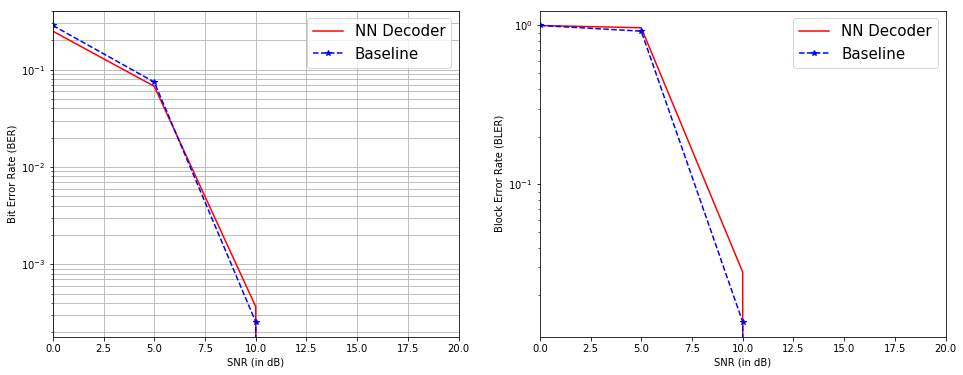

In [6]:
import matplotlib.pyplot as plt

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
utils.visualize_ber_bler(ax1, ax2, ber_logs, bler_logs, Params.SNR_RANGE)
ax1.semilogy()
ax2.semilogy()